# PHATE visualization of ECT leaf images

### Import necessary modules

In [2]:
import os # for dealing with directories
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import pandas as pd # for working with dataframes
import numpy as np # for arrays
from ect import ECT, EmbeddedGraph # for calculating ECTs
from scipy.spatial import ConvexHull # for convex hull
from sklearn.decomposition import PCA # for PCA for normalization
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import phate # for using PHATE 
import scprep # for using PHATE

### Functions

In [3]:
def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

### Define leaf datasets and groups

Create a pandas dataframe, `lf_df`, that contains info about leaves

Data is from [Modified leaf shape contour data](https://figshare.com/articles/dataset/Modified_leaf_shape_contour_data/25435936) (Wang, Willey, and Chitwood, 2024). All folders together are 1.19 GB compressed. Download and unzip all folders and save in a folder named `2017_leaves`.

In [6]:
# a list of folder directories of datasets to analyze
datasets = ["Alstroemeria",
            "Apple",
            "Arabidopsis",
            "Arabidopsis_asymmetry",
            "Brassica/napus",
            "Brassica/rapa",
            "Coleus/Co1",
            "Coleus/Co2",
            "Coleus/Co3",
            "Coleus/Co4",
            "Coleus/Co5",
            "Coleus/Co6",
            "Cotton",
            "Grape/Domesticated_grape/GrapeJune1.2011",
            "Grape/Domesticated_grape/GrapeMay28.2011",
            "Grape/Domesticated_grape/GrapeMay29.2011",
            "Grape/Domesticated_grape/GrapeMay30.2011",
            "Grape/Domesticated_grape/GrapeMay31.2011",
            "Grape/Geneva_2013/Folder1_Jose",
            "Grape/Geneva_2013/Folder2_Tommy",
            "Grape/Geneva_2013/Folder3_Danny",
            "Grape/Geneva_2013/Folder4_Quaneisha",
            "Grape/Geneva_2013/Folder5_Susan",
            "Grape/Geneva_2013/Folder6_Darren",
            "Grape/Geneva_2013/Folder7_Jose2",
            "Grape/Geneva_2013/Folder8_Susan2",
            "Grape/Geneva_2013/Folder9_Tommy2",
            "Grape/Geneva_2013/Folder10_Quaneisha2",
            "Grape/Geneva_2013/Folder11_Darren2",
            "Grape/Geneva_2013/Folder12_Danny",
            "Grape/Geneva_2015/060815",
            "Grape/Geneva_2015/060915",
            "Grape/Geneva_2015/061015",
            "Grape/Geneva_2016/Dan_Geneva_2016",
            "Grape/Geneva_2016/MF_Geneva_2016",
            "Grape/MtVernon_scans/2014_MtVernon_Scans",
            "Grape/MtVernon_scans/2016_MtVernon_Scans",
            "Grass",
            "Ivy",
            "Leafsnap",
            "Passiflora",
            "Pepper",
            "Potato",
            "Tomato_asymmetry",
            "Tomato_BILs/B1",
            "Tomato_BILs/B2",
            "Tomato_BILs/B3",
            "Tomato_chamber/C1",
            "Tomato_chamber/C2",
            "Tomato_chamber/C3",
            "Tomato_chamber/C4",
            "Tomato_chamber/C5",
            "Tomato_entire",
            "Tomato_field/F1",
            "Tomato_field/F2",
            "Tomato_wild/WA",
            "Tomato_wild/WB",
            "Transect/Batch_1_W",
            "Transect/Batch_2_B",
            "Viburnum/V1",
            "Viburnum/V2",
           ]

# make a list of overall groups
groups = [] # store group names

for i in datasets: # for each dataset

    if ("Tomato" in i) & ("/" in i):
        groups.append(i[:i.index('_')]) # then only take up to the underscore
    
    elif "/" in i: # if there are subfolders
        groups.append(i[:i.index('/')]) # then only take the name of the first folder
    elif "_" in i: # if there is a redundant folder with "_" like Arabidopsis
        groups.append(i[:i.index('_')]) # then only take up to the underscore
    else:
        groups.append(i) # otherwise just take the whole name

Create a dataframe with file paths, dataset, and group information.

In [7]:
file_names = [] # store file names
dataset = [] # store dataset names
group = [] # store group names

for i in range(len(datasets)): # for each dataset
    
    curr_dataset = datasets[i] # get current dataset
    curr_group = groups[i] # get current group
    data_dir = "./2017_leaves/"+curr_dataset+"/" # set data directory
    files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
    #file_names.remove('.DS_Store') # remove .DS_Store file
    files.sort() # sort the list of file names

    for j in range(len(files)): # for each file
        
        file_names.append("./2017_leaves/"+curr_dataset+"/"+files[j]) # store file names
        dataset.append(curr_dataset) # store datasets
        group.append(curr_group) # store group
        
# create a pandas dataframe of all file info
lf_df = pd.DataFrame(
    {"group":group,
     "dataset":dataset,
     "file":file_names,
    })

# print out number of each dataset
lf_df["group"].value_counts()

group
Tomato          82034
Coleus          34607
Grape           11379
Apple            9619
Transect         5808
Arabidopsis      5101
Leafsnap         4565
Passiflora       3298
Pepper           3277
Cotton           2885
Viburnum         2422
Alstroemeria     2392
Potato           1840
Brassica         1832
Grass             866
Ivy               865
Name: count, dtype: int64

### Save ECT files for leaves

Save ECT images for leaves.

<div class="alert alert-block alert-warning"">
<b>Careful:</b> This takes ~26 hours to run. Do not execute if you have already saved ECT images to file.
</div>

Create a folder to save the ECT images if it doesn't already exist named `ect_leaf_files`.

In [7]:
path = "ect_leaf_files"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new directory is created!")

The new directory is created!


Save the ECT images to the folder. They will be named by the index in `lf_df` and have the dataset in the filename. We will save ECT images 70 directions by 70 thresholds.

In [24]:
num_dir=70 # set number of directional axes
num_thresh=70 # set number of thresholds each axis

for i in range(len(lf_df)): # for each leaf

    shape = np.load(lf_df["file"].iloc[i]) # load current leaf

    if i%5000==0:
        print(i)

    G = EmbeddedGraph() # initiate a graph
    G.add_cycle(shape) # create graph from shape
    G.set_PCA_coordinates( center_type='min_max', scale_radius=1) # perform PCA and normalize
    myect = ECT(num_dirs = num_dir, num_thresh=num_thresh) # calculate ECT
    myect.set_bounding_radius(1) # set bounding radius
    M = myect.calculateECT(G) # retrieve ECT

    np.save("./ect_leaf_files/"+str(i)+"_"+lf_df["group"].iloc[i], M) # save ECT file




0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000


### Create an ECT leaf array

Read back in saved ECT `.npy` files and save as an array. Add nonseed (bryophyte and lycophyte) data to leaf data into one dataframe for combined analysis.

<div class="alert alert-block alert-warning"">
<b>Careful:</b> It takes ~8 minutes to read in all the leaf ECT images.
</div>

Get the ECT image file names

In [5]:
data_dir = "./ECT_leaf_files/" # set data directory
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
files.remove('.DS_Store') # remove .DS_Store file
files.sort() # sort the list of file names

Create the ECT leaf array and save index and dataset information.

In [6]:
ect_lf_arr = np.zeros((len(files),70,70)) # create an array to save ECT images
ind_lf = [] # a list to store indices in lf_df
dataset_lf = [] # a list to store dataset info

for i in range(len(files)): # for each file

    if i%5000==0: # print every 5000
        print(i)
    
    curr_lf = files[i] # get current file name
    ind_lf.append(curr_lf[:curr_lf.index("_")]) # get index in lf_df
    dataset_lf.append(curr_lf[curr_lf.index("_")+1:curr_lf.index(".")]) # get dataset info

    ect_lf_arr[i,:,:] = np.load("./ect_leaf_files/"+curr_lf) # load and save lf ECT to array


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000


Similar to the leaf array, read in non-seed plant leaf data from bryophytes and lycophytes and create ECT images and save to array together with dataset and index information. The data is available in this folder as the zipped file `lyco_bryo_shapes`. Use the same folder name for the data itself once unzipped.

First, create a `nonseed_df` similar to `lf_df` with file path info.

In [7]:
data_dir = "./lyco_bryo_shapes/" # set data directory
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
#files.remove('.DS_Store') # remove .DS_Store file
files.sort() # sort the list of file names

file = [] # list to store file names
group = [] # list to store group
dataset = [] # a list to store dataset

for i in range(len(files)): # for each nonseed "leaf"

    file.append("./lyco_bryo_shapes/"+files[i]) # save the file path
    group.append("nonseed") # save group
    dataset.append("nonseed") # save dataset

nonseed_df = pd.DataFrame({ # create a nonseed df
    "group":group,
    "dataset":dataset,
    "file":file
})

# combine into one dataframe, reset index
all_df = pd.concat([lf_df,nonseed_df],ignore_index=True)

Calculate non-seed plant ECT images

In [8]:
num_dir=70 # set number of directional axes
num_thresh=70 # set number of thresholds each axis

nonseed_ect_arr = np.zeros((len(nonseed_df),70,70)) # to store nonseed ECTs
ind_nonseed = [] # a list to store indices in nonseed_df
dataset_nonseed = [] # a list to store dataset info

counter = 172790 # start counter at end of leaf ECT indices

for i in range(len(nonseed_df)): # for each non-seed plant leaf

    shape = np.loadtxt(nonseed_df["file"].iloc[i]) # load current leaf

    if i%20==0:
        print(i)

    G = EmbeddedGraph() # initiate a graph
    G.add_cycle(shape) # create graph from shape
    G.set_PCA_coordinates( center_type='min_max', scale_radius=1) # perform PCA and normalize
    myect = ECT(num_dirs = num_dir, num_thresh=num_thresh) # calculate ECT
    myect.set_bounding_radius(1) # set bounding radius
    M = myect.calculateECT(G) # retrieve ECT

    nonseed_ect_arr[i,:,:] = M # save ECT file to array
    ind_nonseed.append(counter) # add the index
    counter+=1 # advance counter
    dataset_nonseed.append("nonseed")



0
20
40
60
80
100
120


Create overall ECT array

In [9]:
all_ECT_arr = np.row_stack((ect_lf_arr, nonseed_ect_arr))

np.shape(all_ECT_arr)

(172916, 70, 70)

Create an `all_ECT_df` that refers back to `all_df` by index

In [10]:
leaf_ect_df = pd.DataFrame({ # ECT leaf dataframe
    "index":ind_lf,
    "dataset":dataset_lf})

nonseed_ect_df = pd.DataFrame({ # ECT nonseed dataframe
    "index":ind_nonseed,
    "dataset":dataset_nonseed})

# combine leaf and nonseed ECT dataframes
all_ECT_df = pd.concat([leaf_ect_df,nonseed_ect_df],ignore_index=True)

### Calculate width-to-length ratio and solidity

<div class="alert alert-block alert-warning"">
<b>Careful:</b> It takes ~16 minutes to calculate solidity and aspect ratio. If saved already, read in the file leaf_data.csv instead
</div>

In [93]:
solidity8 = [] # store solidity values
wl_ratio = [] # store width-to-length ratio values
files = [] # to store file paths

for i in range(len(all_ECT_df)): # for each leaf

    if i%5000==0:
        print(i)
    
    ind = int(all_ECT_df["index"].iloc[i]) # get the index in all_df for leaf

    curr_file = all_df["file"].iloc[ind] # get file path
    files.append(curr_file) # store current file path

    # load in file
    if ".npy" in curr_file:
        shape = np.load(curr_file)
    elif ".txt" in curr_file:
        shape = np.loadtxt(curr_file)
     
    # calculate solidity
    hull = ConvexHull(shape) # calculate convex hull of current shape
    vertices = hull.vertices # isolate vertex indices of convex hull
    area = poly_area(shape[:,0], shape[:,1]) # calculate area
    convex_area = poly_area(shape[vertices,0], shape[vertices,1]) # calculate convex area
    solidity8.append( (area / convex_area)**8 ) # calculate solidity**8 and store

    # calculate length-to-width ratio
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    length = np.max(pca_scores[:,0])-np.min(pca_scores[:,0]) # get length
    width = np.max(pca_scores[:,1])-np.min(pca_scores[:,1]) # get width
    wl_ratio.append(width/length) # store length-to-width ratio

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000


In [104]:
# create the dataframe
df = pd.DataFrame({
    "solidity8":solidity8,
    "wl_ratio":wl_ratio,
    "group":all_ECT_df["dataset"],
    "file":files})

# save the dataframe to file
df.to_csv("leaf_data.csv")

### PHATE - Potential of Heat-diffusion for Affinity-based Trajectory Embedding
<div class="alert alert-block alert-warning"">
<b>Careful:</b> It takes ~1 hour to calculate PHATE. If already run, load in the PHATE scores below.
</div>

In [8]:
# read in the metadata
df = pd.read_csv("./leaf_data.csv")

# check the df
df.head()

,Unnamed: 0,solidity8,wl_ratio,group,file
0,0,0.310743,0.259633,Alstroemeria,./2017_leaves/Alstroemeria/a10_AB_clock043.npy
1,1,0.365751,0.622601,Tomato,./2017_leaves/Tomato_BILs/B3/Z037l2.npy
2,2,0.589355,0.727564,Tomato,./2017_leaves/Tomato_BILs/B3/Z037l3.npy
3,3,0.595287,0.953010,Tomato,./2017_leaves/Tomato_BILs/B3/Z037l4.npy
4,4,0.587968,0.736493,Tomato,./2017_leaves/Tomato_BILs/B3/Z037l5.npy


Peform PHATE. Note: default settings (which should be used for final figures) take about an hour to run.

For a faster run (with minimal effects on final output) that takes about 2 minutes, use the following arguments:

```python
phate_operator = phate.PHATE(n_components=3,
                                     knn=5,
                                     knn_max=25, # For speed
                                     knn_dist="euclidean",
                                     mds_dist="euclidean",
                                     mds="metric",
                                     mds_solver="sgd",
                                     n_jobs=-2, # For speed
                                     n_pca=20, # For speed
                                     random_state=42,
                                     )
```

In [ ]:
# create a flat array
flat_arr = np.reshape(all_ECT_arr, (np.shape(all_ECT_arr)[0],
                                    np.shape(all_ECT_arr)[1]*np.shape(all_ECT_arr)[2]))

# create the PHATE embedding and transform
phate_operator = phate.PHATE(n_components=3,random_state=42)
phate_leaf = phate_operator.fit_transform(flat_arr)

Save the output

In [20]:
np.save("phate_scores_leaves_fast.npy", phate_leaf)

### Visualization

Load in the PHATE scores

In [4]:
phate_fast = np.load("./phate_scores_leaves.npy")
np.shape(phate_fast)

(172916, 3)

Load in the associated metadata

In [5]:
df = pd.read_csv("./leaf_data.csv")

Add PHATE scores to dataframe

In [6]:
df["phate1"] = phate_fast[:,0]
df["phate2"] = phate_fast[:,1]
df["phate3"] = phate_fast[:,2]

Create masks

In [7]:
diverse_lfs = df[(df["group"]=="Leafsnap") | (df["group"]=="Transect") | (df["group"]=="nonseed") ]
specific_lfs = df[df["group"]!="Leafsnap"]
specific_lfs = specific_lfs[specific_lfs["group"]!="Transect"]
specific_lfs = specific_lfs[specific_lfs["group"]!="nonseed"]

# create dictionary color palette
pal = {
    "Alstroemeria":"#8a3ffc",
    "Tomato":"#ff7eb6",
    "Apple":"#6fdc8c",
    "Arabidopsis":"#d2a106",
    "Viburnum":"#ba4e00",
    "Brassica":"#33b1ff",
    "Coleus":"#fa4d56",
    "Cotton":"#4589ff",
    "Grape":"#08bdba",
    "Grass":"#d4bbff",
    "Ivy":"#007d79",
    "Passiflora":"#fff1f1",
    "Pepper":"#d12771",
    "Potato":"#bae6ff"}


Find leaf shape indices to visualize

In [8]:
# number of intervals across phate axes
num_ph1_int = 20
num_ph2_int = 20
num_ph3_int = 20

# create intervals across PHATE values
ph1_vals = np.linspace(np.min(df["phate1"]),np.max(df["phate1"]),num_ph1_int)
ph2_vals = np.linspace(np.min(df["phate2"]),np.max(df["phate2"]),num_ph2_int)
ph3_vals = np.linspace(np.min(df["phate3"]),np.max(df["phate3"]),num_ph3_int)

# store indices of leaves to analyze PHATE 1 & 2
lf_inds_12 = []

# store indices of leaves to analyze PHATE 1 & 3
lf_inds_13 = []

# store indices of leaves to analyze PHATE 2 & 3
lf_inds_23 = []

# select PHATE 1 & 2 leaves
for i in range(len(ph1_vals)-1): # for the PHATE 1 vals
    for j in range(len(ph2_vals)-1): # for the PHATE 2 vals
        # create df of selected leaves
        select_df = df[((df["phate1"]>=ph1_vals[i])&(df["phate1"]<=ph1_vals[i+1])) & 
                       ((df["phate2"]>=ph2_vals[j])&(df["phate2"]<=ph2_vals[j+1]))]
        if len(select_df)==0: # continue if no leaves
            continue
        else: # else save the index of one leaf
            lf_inds_12.append(select_df.sample(n=1,random_state=42).index[0])

# select PHATE 1 & 3 leaves
for i in range(len(ph1_vals)-1): # for the PHATE 1 vals
    for j in range(len(ph3_vals)-1): # for the PHATE 3 vals
        # create df of selected leaves
        select_df = df[((df["phate1"]>=ph1_vals[i])&(df["phate1"]<=ph1_vals[i+1])) & 
                       ((df["phate3"]>=ph3_vals[j])&(df["phate3"]<=ph3_vals[j+1]))]
        if len(select_df)==0: # continue if no leaves
            continue
        else: # else save the index of one leaf
            lf_inds_13.append(select_df.sample(n=1,random_state=42).index[0])

# select PHATE 2 & 3 leaves
for i in range(len(ph2_vals)-1): # for the PHATE 2 vals
    for j in range(len(ph3_vals)-1): # for the PHATE 3 vals
        # create df of selected leaves
        select_df = df[((df["phate2"]>=ph2_vals[i])&(df["phate2"]<=ph2_vals[i+1])) & 
                       ((df["phate3"]>=ph3_vals[j])&(df["phate3"]<=ph3_vals[j+1]))]
        if len(select_df)==0: # continue if no leaves
            continue
        else: # else save the index of one leaf
            lf_inds_23.append(select_df.sample(n=1,random_state=42).index[0])
        


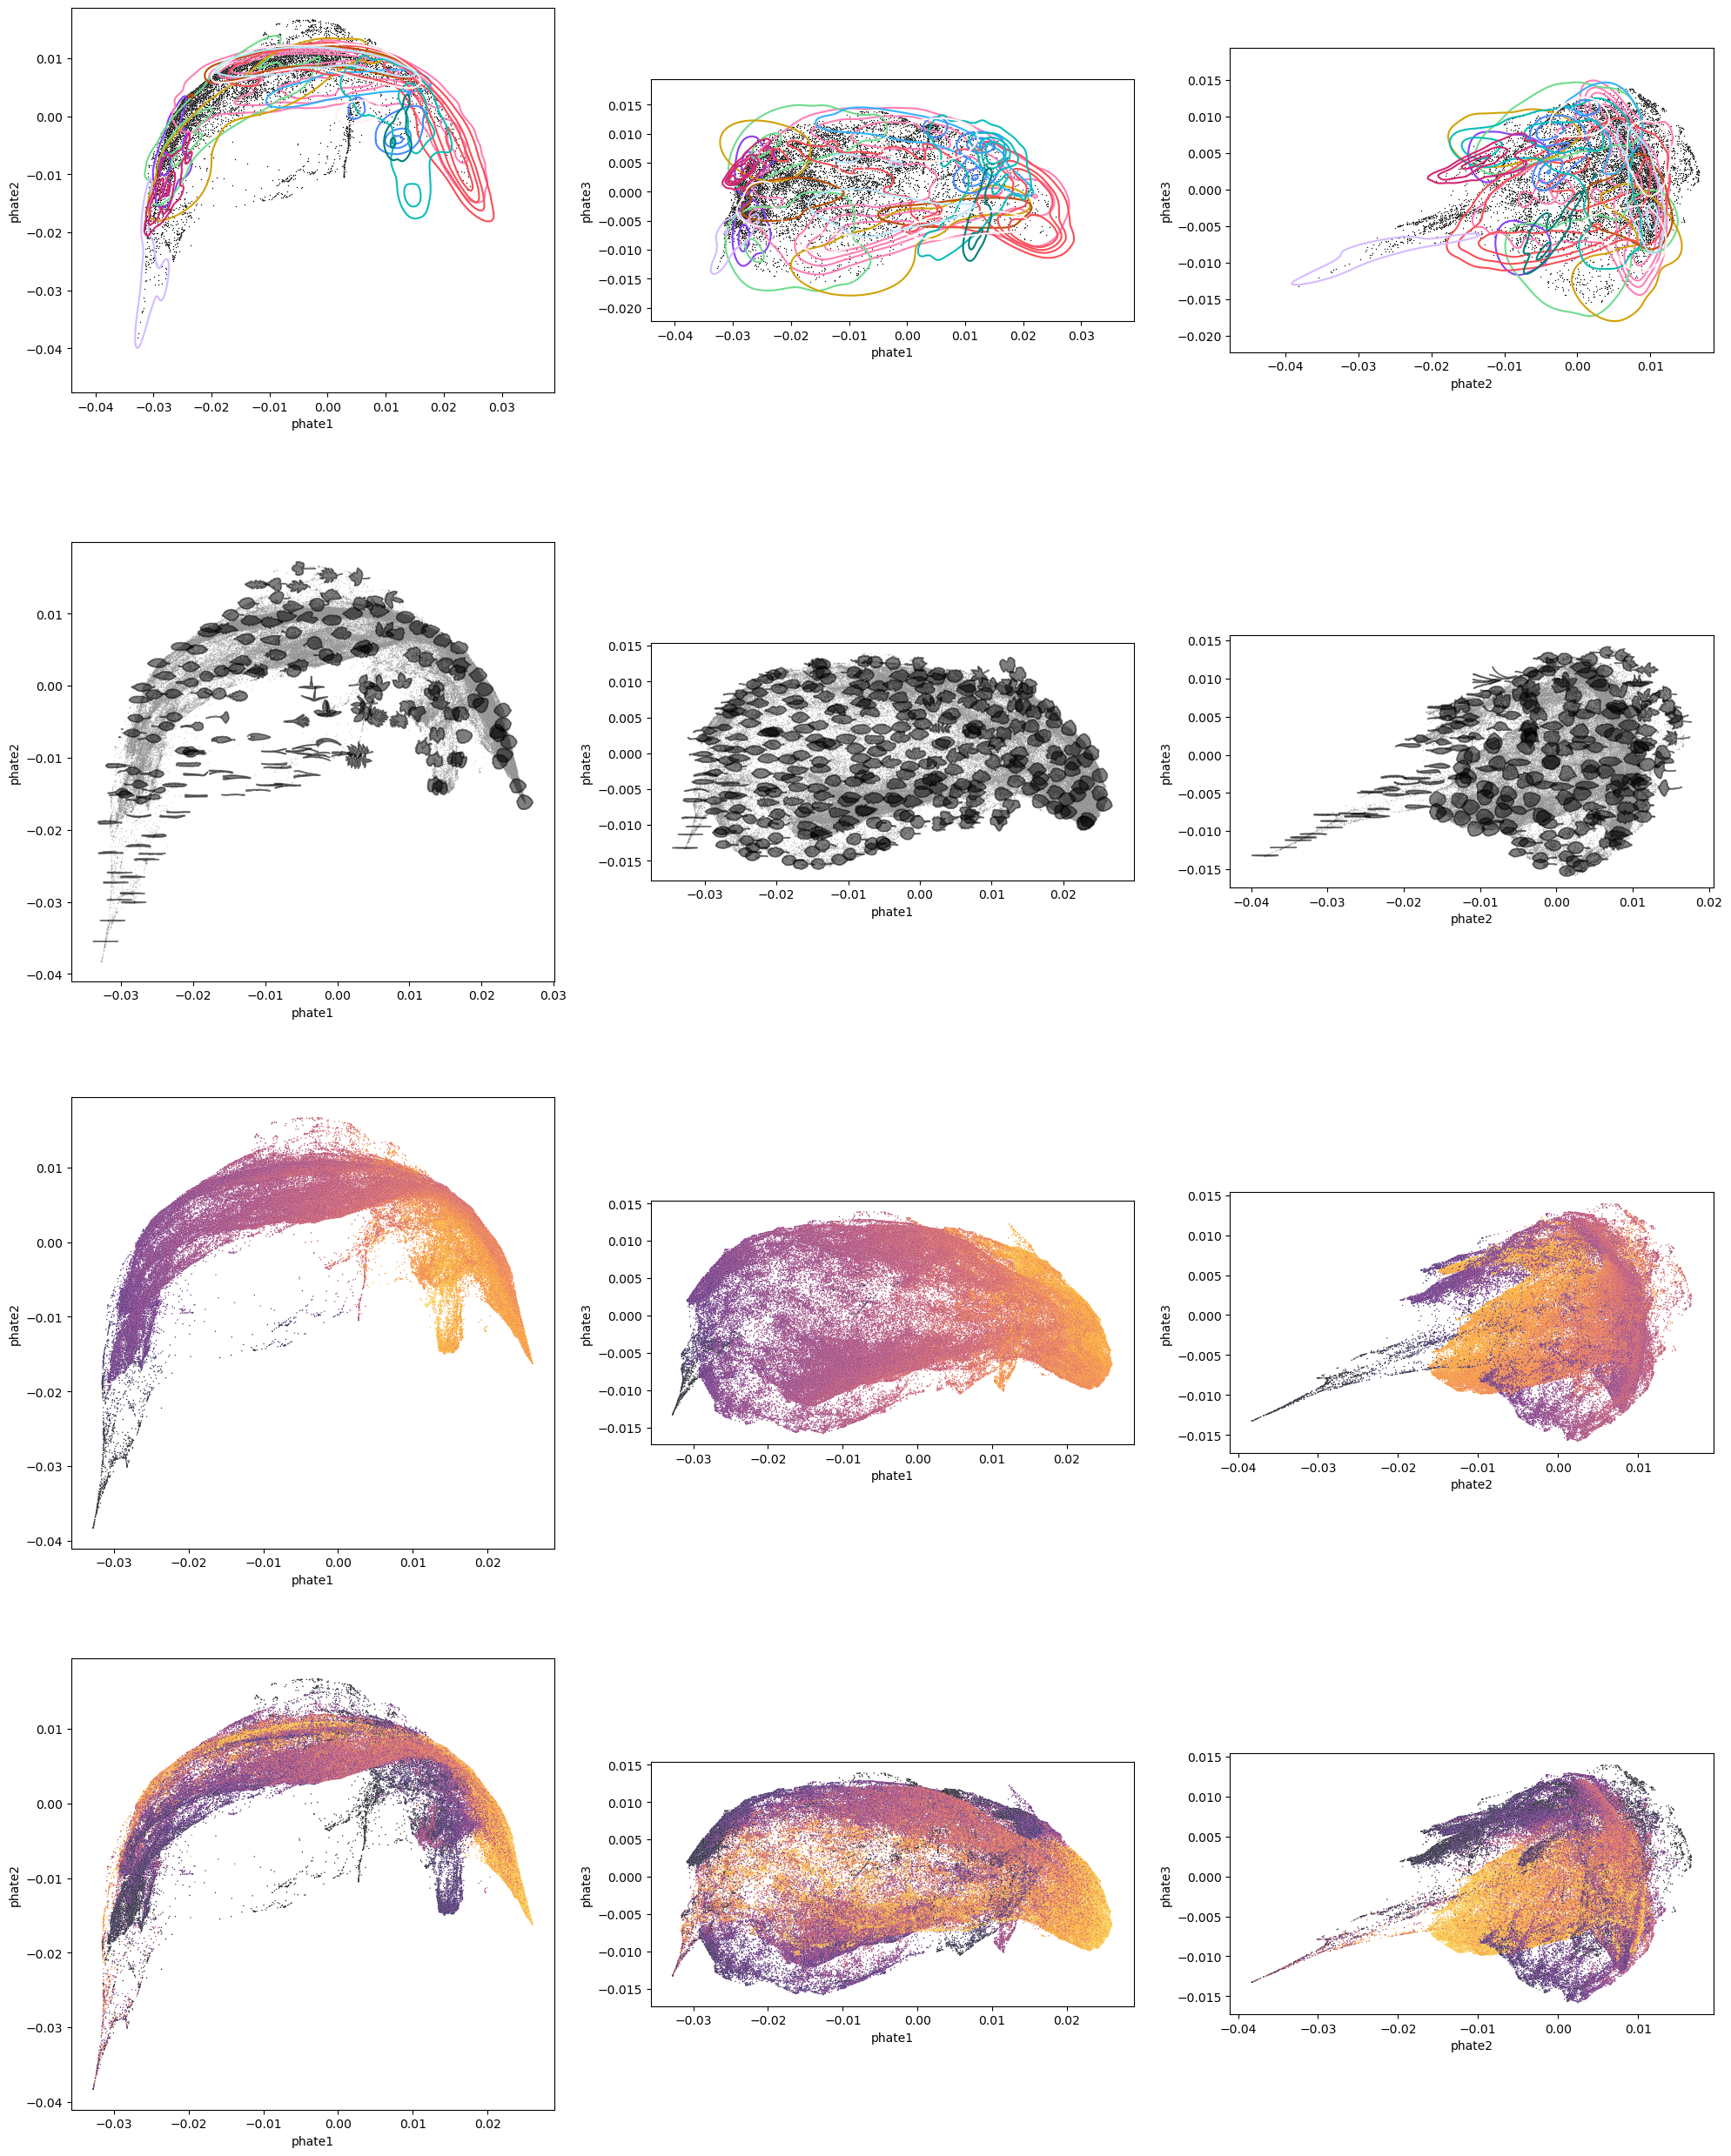

In [9]:
plt.figure(figsize=(20,26))

##############
### groups ###
##############

plt.subplot(4,3,1)
sns.scatterplot(data=diverse_lfs, x="phate1", y="phate2", s=1, legend=False, c="k")
sns.kdeplot(data=specific_lfs, x="phate1", y="phate2", hue="group",legend=False, fill=None, palette=pal, levels=5)
plt.gca().set_aspect("equal")

plt.subplot(4,3,2)
sns.scatterplot(data=diverse_lfs, x="phate1", y="phate3", s=1, legend=False, c="k")
sns.kdeplot(data=specific_lfs, x="phate1", y="phate3", hue="group", legend=False, fill=None, palette=pal, levels=5)
plt.gca().set_aspect("equal")

plt.subplot(4,3,3)
sns.scatterplot(data=diverse_lfs, x="phate2", y="phate3", s=1, legend=False, c="k")
sns.kdeplot(data=specific_lfs, x="phate2", y="phate3", hue="group", legend=False, fill=None, palette=pal, levels=5)
plt.gca().set_aspect("equal")

##############
### shapes ###
##############

scale = 0.001
a = 0.5

plt.subplot(4,3,4)
sns.scatterplot(data=df, x="phate1", y="phate2", s=1, alpha=0.3, c="gray")
plt.gca().set_aspect("equal")
for i in range(len(lf_inds_12)):
    plt.subplot(4,3,4)
    curr_lf = df["file"].iloc[lf_inds_12[i]]
    if ".txt" in curr_lf:
        shape = np.loadtxt(curr_lf)
    elif ".npy" in curr_lf:
        shape = np.load(curr_lf)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    plt.fill(pca_scores[:,0]*scale+df["phate1"].iloc[lf_inds_12[i]],
             pca_scores[:,1]*scale+df["phate2"].iloc[lf_inds_12[i]],
             c="k", alpha=a)
    plt.gca().set_aspect("equal")

plt.subplot(4,3,5)
sns.scatterplot(data=df, x="phate1", y="phate3", s=1, alpha=0.3, c="gray")
plt.gca().set_aspect("equal")
for i in range(len(lf_inds_13)):
    plt.subplot(4,3,5)
    curr_lf = df["file"].iloc[lf_inds_13[i]]
    if ".txt" in curr_lf:
        shape = np.loadtxt(curr_lf)
    elif ".npy" in curr_lf:
        shape = np.load(curr_lf)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    plt.fill(pca_scores[:,0]*scale+df["phate1"].iloc[lf_inds_13[i]],
             pca_scores[:,1]*scale+df["phate3"].iloc[lf_inds_13[i]],
             c="k", alpha=a)
    plt.gca().set_aspect("equal")

plt.subplot(4,3,6)
sns.scatterplot(data=df, x="phate2", y="phate3", s=1, alpha=0.3, c="gray")
plt.gca().set_aspect("equal")
for i in range(len(lf_inds_23)):
    plt.subplot(4,3,6)
    curr_lf = df["file"].iloc[lf_inds_23[i]]
    if ".txt" in curr_lf:
        shape = np.loadtxt(curr_lf)
    elif ".npy" in curr_lf:
        shape = np.load(curr_lf)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    plt.fill(pca_scores[:,0]*scale+df["phate2"].iloc[lf_inds_23[i]],
             pca_scores[:,1]*scale+df["phate3"].iloc[lf_inds_23[i]],
             c="k", alpha=a)
    plt.gca().set_aspect("equal")
    

#############################
### width-to-length ratio ###
#############################

plt.subplot(4,3,7)
sns.scatterplot(data=df, x="phate1", y="phate2", hue="wl_ratio", s=1, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.subplot(4,3,8)
sns.scatterplot(data=df, x="phate1", y="phate3", hue="wl_ratio", s=1, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.subplot(4,3,9)
sns.scatterplot(data=df, x="phate2", y="phate3", hue="wl_ratio", s=1, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

################
### solidity ###
################

plt.subplot(4,3,10)
sns.scatterplot(data=df, x="phate1", y="phate2", hue="solidity8", s=1, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.subplot(4,3,11)
sns.scatterplot(data=df, x="phate1", y="phate3", hue="solidity8", s=1, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.subplot(4,3,12)
sns.scatterplot(data=df, x="phate2", y="phate3", hue="solidity8", s=1, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.tight_layout()


Create legend for groups

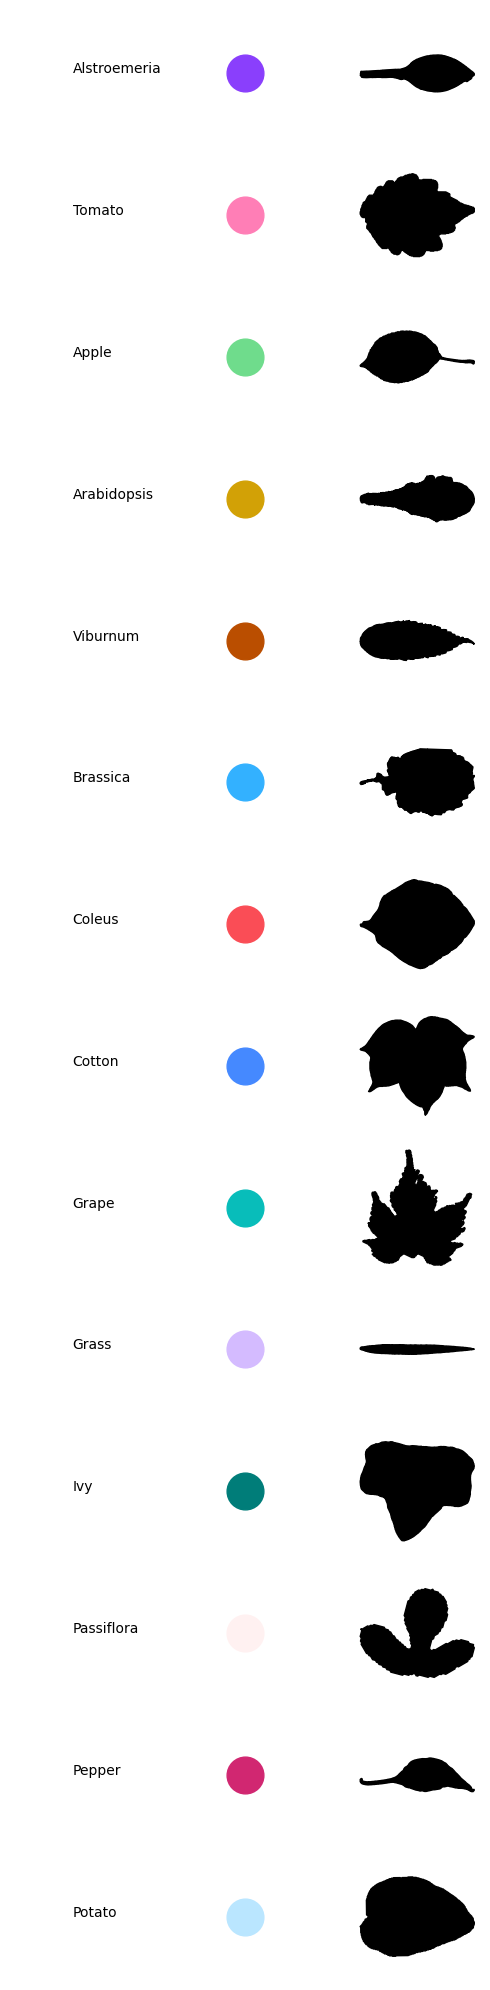

In [10]:
names = specific_lfs["group"].unique()
counter=1

plt.figure(figsize=(5,20))

for i in range(len(names)):

    plt.subplot(14,3,counter)
    plt.text(0.5,0.5,names[i], fontsize=10)
    plt.axis("off")
    counter+=1
    
    plt.subplot(14,3,counter)
    plt.scatter(0,0,c=pal[names[i]],s=700)
    plt.axis("off")
    counter+=1
    
    plt.subplot(14,3,counter)
    lf = specific_lfs["file"][specific_lfs["group"]==names[i]].sample(n=1, random_state=3)
    shape = np.load(lf.item())
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    plt.fill(pca_scores[:,0], pca_scores[:,1], c="k")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    counter+=1
    
plt.tight_layout()

Create legend for width-to-length ratio

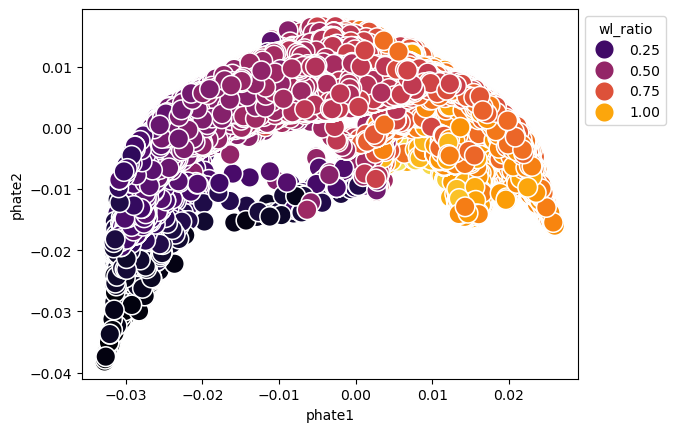

In [11]:
ax = sns.scatterplot(data=df, x="phate1", y="phate2", hue="wl_ratio", s=200, legend=True, palette="inferno")
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))

Create legend for solidity

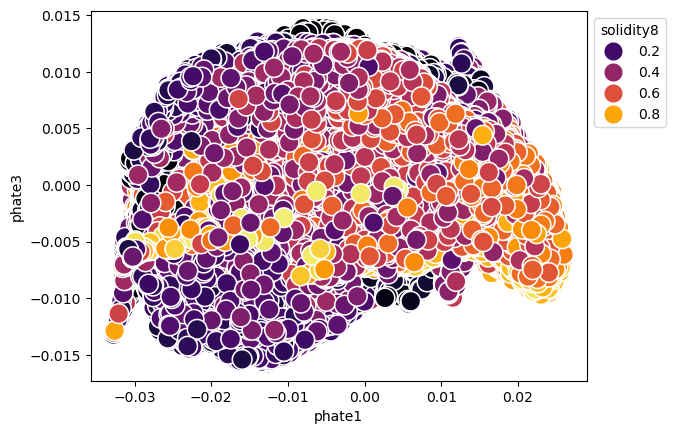

In [12]:
ax = sns.scatterplot(data=df, x="phate1", y="phate3", hue="solidity8", s=200, legend=True, palette="inferno")
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))